In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

### Regression model - Predicting Type A behaviour

Y variable - typea
X variables - sbp, tobacco, ldl, adiposity, famhist, obesity, alcohol, age

Note that chd is not included as it is the original target variable

In [2]:
df = pd.read_csv("south_african_heart_disease.csv", encoding='ISO-8859-1')

# Drop irrelevant variables
df.drop('row.names', axis=1, inplace=True)

# Transform famhist to binary values
df['famhist'] = np.where(df['famhist'] == 'Present', 1, 0).astype(int)
df.describe()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,0.415584,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,0.493357,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,0.000000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,0.000000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,0.000000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,1.000000,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,1.000000,78.000000,46.580000,147.190000,64.000000,1.000000


### Data Preprocessing

- Log transformation of alcohol and tobacco usage
- Normalization and standardisation of all parameters apart from famhist

In [3]:
# Log-transformation of alcohol and tobacco
df['log_alcohol'] = np.log(df['alcohol'] + 1)
df['log_tobacco'] = np.log(df['tobacco'] + 1)

# Columns to exclude for normalisation
excluded_cols = ['chd']
categorical_cols = ['famhist']

# Numerical columns
numerical_cols = ['ldl', 'adiposity', 'sbp', 'obesity', 'age', 'log_alcohol', 'log_tobacco']

# Initialize StandardScaler
scaler = StandardScaler()

# Apply Z-score normalization only to selected numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [4]:
X = df[numerical_cols + categorical_cols]
Y = df['typea']

### Selection of regularization parameter

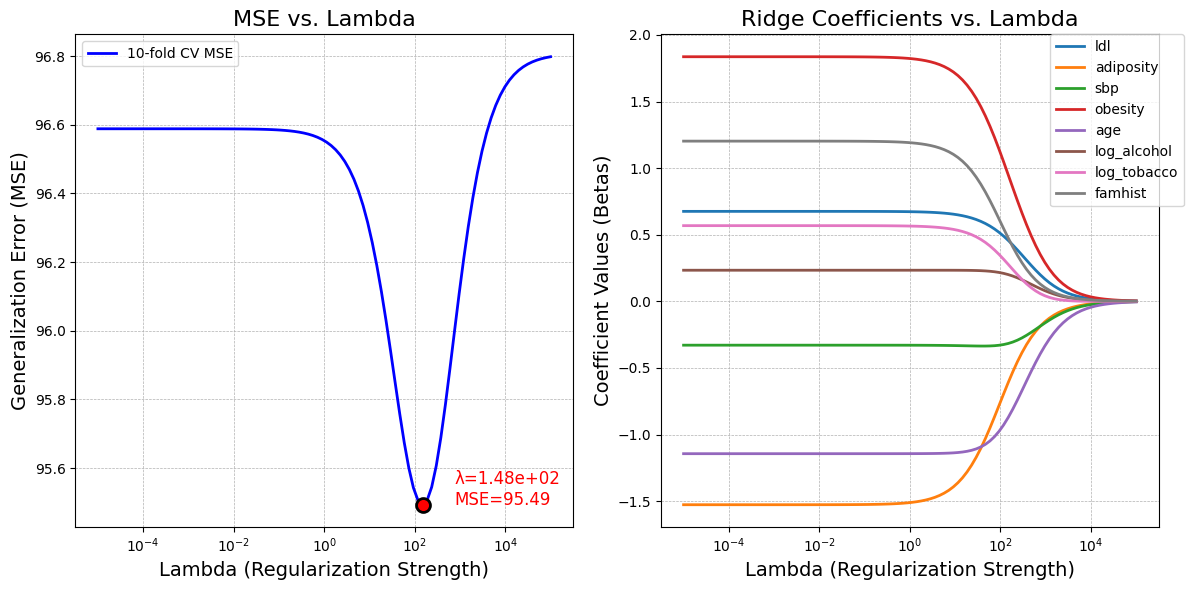

In [5]:
# Range of lambda (regularization strength) values to test
lambda_range = np.logspace(-5, 5, 100)

# Initialize cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store generalization errors (RMSE) for each lambda value
errors = []
coefs = []  # To store betas for each lambda

# Loop over lambda values
for lam in lambda_range:
    fold_errors = []
    
    # Ridge model
    model = Ridge(alpha=lam)
    model.fit(X, Y)
    
    # Store coefficients
    coefs.append(model.coef_)
    
    # Cross-validation for RMSE
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        fold_errors.append(mean_squared_error(Y_test, Y_pred))
    
    # Average error across folds
    errors.append(np.mean(fold_errors))

# Convert coefficients list to NumPy array for easy plotting
coefs = np.array(coefs)

# Find the best lambda (minimum MSE)
min_mse_index = np.argmin(errors)
min_lambda = lambda_range[min_mse_index]
min_mse = errors[min_mse_index]

# --- MSE Plot ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.semilogx(lambda_range, errors, label='10-fold CV MSE', color='blue', linewidth=2)

# Highlight best lambda
plt.scatter(min_lambda, min_mse, color='red', s=100, zorder=5, edgecolors='black', linewidth=2)
plt.text(x=min_lambda * 5, y=min_mse, s=f'λ={min_lambda:.2e}\nMSE={min_mse:.2f}', color='red', fontsize=12)

plt.xlabel('Lambda (Regularization Strength)', fontsize=14)
plt.ylabel('Generalization Error (MSE)', fontsize=14)
plt.title('MSE vs. Lambda', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# --- Beta Coefficients Plot ---
plt.subplot(1, 2, 2)
for i, feature in enumerate(X.columns):
    plt.semilogx(lambda_range, coefs[:, i], label=feature, linewidth=2)  # Each beta vs. lambda

plt.xlabel('Lambda (Regularization Strength)', fontsize=14)
plt.ylabel('Coefficient Values (Betas)', fontsize=14)
plt.title('Ridge Coefficients vs. Lambda', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10, bbox_to_anchor=(1.05, 1), borderaxespad=0.)  # Place legend outside

plt.tight_layout()
plt.show()

In [6]:
# Find the lambda with the lowest RMSE (the best lambda)
min_rmse_index = np.argmin(errors)
best_lambda = lambda_range[min_rmse_index]

# Train the Ridge regression model with the best lambda (from cross-validation)
final_model = Ridge(alpha=best_lambda)
final_model.fit(X, Y)

# Get the coefficients (betas) from the model
coefficients = final_model.coef_

# Create a DataFrame to tabulate the beta values
feature_names = X.columns
beta_table = pd.DataFrame({
    'Feature': feature_names,
    'Beta': coefficients
})

# Sort by absolute value of Beta to show the most influential features first
beta_table['Abs Beta'] = np.abs(beta_table['Beta'])
beta_table = beta_table.sort_values(by='Abs Beta', ascending=False).drop('Abs Beta', axis=1)

# Display the table of coefficients
print(f"Best Lambda: {best_lambda}")
print(beta_table)

Best Lambda: 148.49682622544634
       Feature      Beta
3      obesity  0.950328
4          age -0.871999
1    adiposity -0.610069
7      famhist  0.475680
0          ldl  0.457567
2          sbp -0.316495
6  log_tobacco  0.277540
5  log_alcohol  0.200790


### PCA of features (feature selection)

sdp and adiposity have the wrong coefficient signs (by common sense they should be positively related). Hence, from our first report, I planned to just use PCA to remove those that do not contribute much to the variance

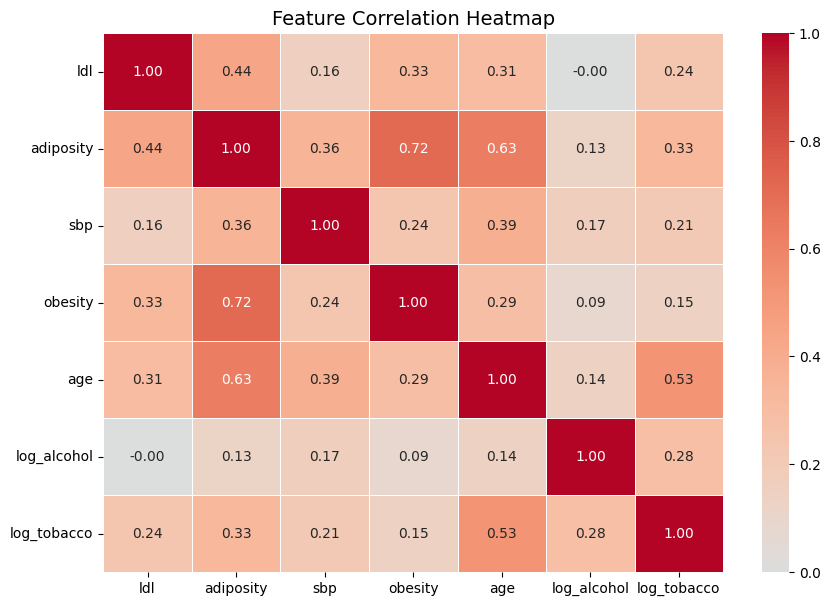

In [7]:
# Compute correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0)

# Add title
plt.title("Feature Correlation Heatmap", fontsize=14)

# Show plot
plt.show()

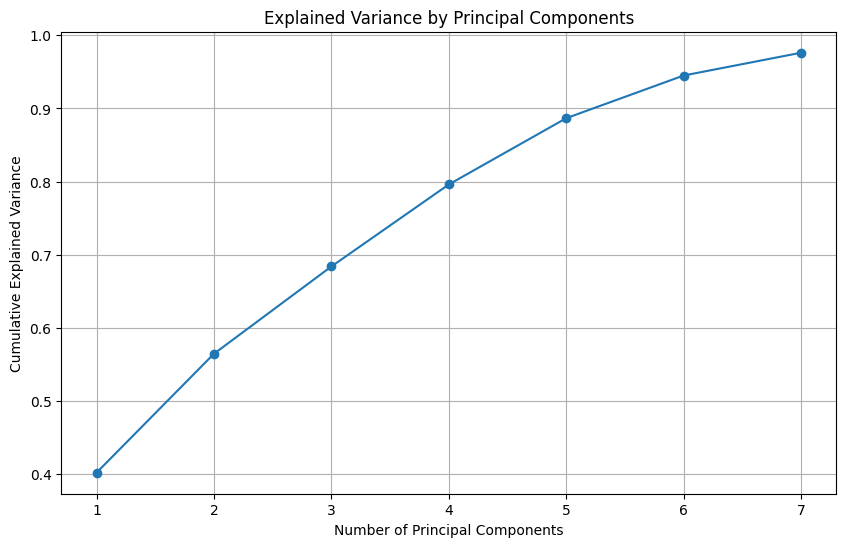

Number of components kept: 6


In [8]:
# Apply PCA
pca = PCA(n_components=len(numerical_cols))  # You can choose fewer components as needed
X_pca = pca.fit_transform(X)

# Variance explained by each component
explained_variance = pca.explained_variance_ratio_

# Cumulative variance
cumulative_variance = np.cumsum(explained_variance)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Decide how many components to keep (e.g., keep enough to explain 90% of the variance)
threshold = 0.9
n_components_to_keep = np.argmax(cumulative_variance >= threshold) + 1

# Transform the data using the selected number of components
pca = PCA(n_components=n_components_to_keep)
X_pca_selected = pca.fit_transform(X)

# X_pca_selected is now the data with reduced dimensionality and removed multicollinearity
print(f"Number of components kept: {n_components_to_keep}")

In [9]:
# Standardize the data (Z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to the scaled data
pca = PCA(n_components=len(numerical_cols))  # We can choose a maximum of 'len(numerical_cols)' components
X_pca = pca.fit_transform(X_scaled)

# Compute the cumulative variance explained by each component
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Select the number of components that explain 90% of the variance
n_components_selected = np.argmax(cumulative_variance >= 0.90) + 1  # Adding 1 because Python indexing starts from 0

# Use only the selected components
X_selected = X_pca[:, :n_components_selected]

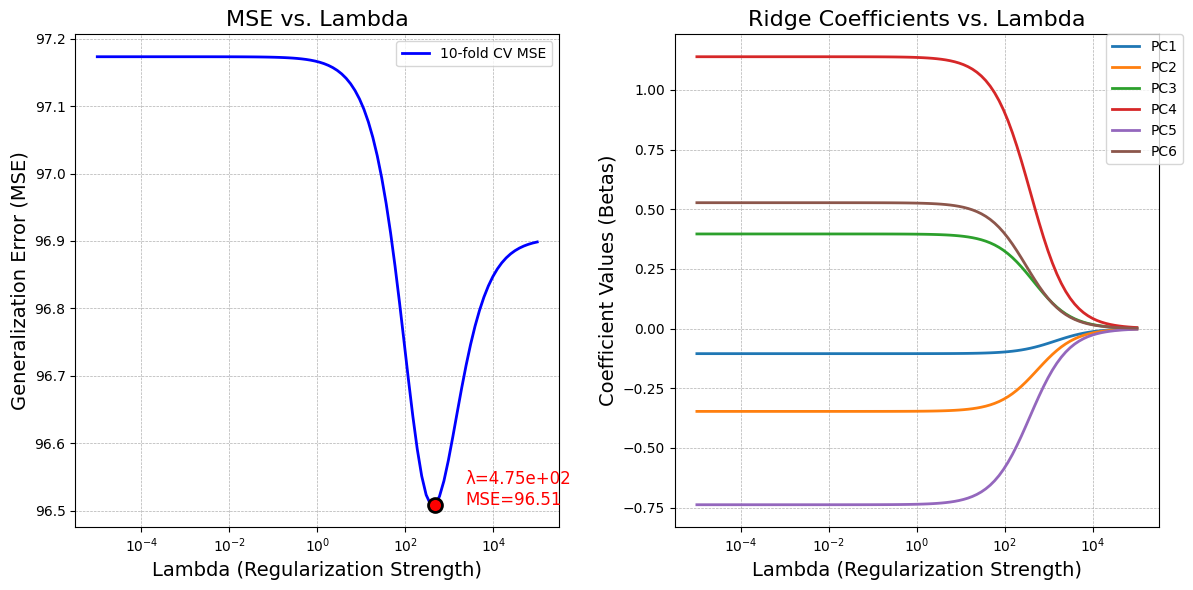

In [10]:
# Range of lambda (regularization strength) values to test
lambda_range = np.logspace(-5, 5, 100)

# Initialize cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=2450)

# Store generalization errors (MSE) for each lambda value
errors = []
coefs = []  # To store betas for each lambda

# Loop over lambda values
for lam in lambda_range:
    fold_errors = []
    
    # Ridge model
    model = Ridge(alpha=lam)
    model.fit(X_selected, Y)  # Fit model on full dataset to get betas
    
    # Store coefficients
    coefs.append(model.coef_)
    
    # Cross-validation for MSE
    for train_index, test_index in kf.split(X_selected):
        X_train, X_test = X_selected[train_index], X_selected[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        fold_errors.append(mean_squared_error(Y_test, Y_pred))  # MSE
    
    # Average error across folds
    errors.append(np.mean(fold_errors))

# Convert coefficients list to NumPy array for easy plotting
coefs = np.array(coefs)

# Find the best lambda (minimum MSE)
min_mse_index = np.argmin(errors)
min_lambda = lambda_range[min_mse_index]
min_mse = errors[min_mse_index]

# --- MSE Plot ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.semilogx(lambda_range, errors, label='10-fold CV MSE', color='blue', linewidth=2)

# Highlight best lambda
plt.scatter(min_lambda, min_mse, color='red', s=100, zorder=5, edgecolors='black', linewidth=2)
plt.text(x=min_lambda * 5, y=min_mse, s=f'λ={min_lambda:.2e}\nMSE={min_mse:.2f}', color='red', fontsize=12)

plt.xlabel('Lambda (Regularization Strength)', fontsize=14)
plt.ylabel('Generalization Error (MSE)', fontsize=14)
plt.title('MSE vs. Lambda', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# --- Beta Coefficients Plot ---
plt.subplot(1, 2, 2)
for i, feature in enumerate([f"PC{i+1}" for i in range(X_selected.shape[1])]):
    plt.semilogx(lambda_range, coefs[:, i], label=feature, linewidth=2)  # Each beta vs. lambda

plt.xlabel('Lambda (Regularization Strength)', fontsize=14)
plt.ylabel('Coefficient Values (Betas)', fontsize=14)
plt.title('Ridge Coefficients vs. Lambda', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10, bbox_to_anchor=(1.05, 1), borderaxespad=0.)  # Place legend outside

plt.tight_layout()
plt.show()

### Validating number of hidden layers for ANN

In [11]:
import warnings

# Mute ConvergenceWarnings for MLPRegressor
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.neural_network")

hidden_units_range = list(range(1, 21))
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=2450)

avg_train_mse_list = []
avg_test_mse_list = []

for h in hidden_units_range:
    train_mse_list = []
    test_mse_list = []

    for train_index, test_index in kf.split(X_selected):
        X_train, X_test = X_selected[train_index], X_selected[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        model = MLPRegressor(hidden_layer_sizes=(h,), max_iter=1000, alpha=10, random_state=2450)
        model.fit(X_train, Y_train)

        Y_train_pred = model.predict(X_train)
        Y_test_pred = model.predict(X_test)

        train_mse = np.mean((Y_train - Y_train_pred) ** 2)
        test_mse = np.mean((Y_test - Y_test_pred) ** 2)

        train_mse_list.append(train_mse)
        test_mse_list.append(test_mse)

    avg_train_mse = np.mean(train_mse_list)
    avg_test_mse = np.mean(test_mse_list)
    print(f'Number of Hidden Units : {h} | {n_splits}-fold Train MSE: {avg_train_mse} | {n_splits}-fold Test MSE: {avg_test_mse}')
    avg_train_mse_list.append(avg_train_mse)
    avg_test_mse_list.append(avg_test_mse)


Number of Hidden Units : 1 | 10-fold Train MSE: 2719.734036921738 | 10-fold Test MSE: 2719.7726159010185
Number of Hidden Units : 2 | 10-fold Train MSE: 1394.4283534814672 | 10-fold Test MSE: 1430.5790906689615
Number of Hidden Units : 3 | 10-fold Train MSE: 2587.6572300496314 | 10-fold Test MSE: 2587.6774948432244
Number of Hidden Units : 4 | 10-fold Train MSE: 666.6429630166579 | 10-fold Test MSE: 697.6532802566112
Number of Hidden Units : 5 | 10-fold Train MSE: 171.15563768846815 | 10-fold Test MSE: 186.4438921624729
Number of Hidden Units : 6 | 10-fold Train MSE: 151.43937070414586 | 10-fold Test MSE: 168.5590268244586
Number of Hidden Units : 7 | 10-fold Train MSE: 197.47303850371333 | 10-fold Test MSE: 218.80423059429822
Number of Hidden Units : 8 | 10-fold Train MSE: 129.27693209014714 | 10-fold Test MSE: 142.267958254209
Number of Hidden Units : 9 | 10-fold Train MSE: 120.1738075486182 | 10-fold Test MSE: 133.76087738572647
Number of Hidden Units : 10 | 10-fold Train MSE: 121.2

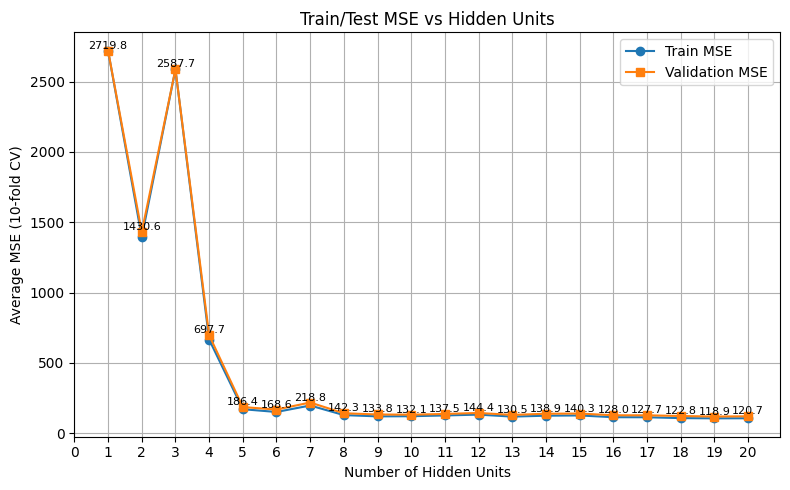

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(hidden_units_range, avg_train_mse_list, label='Train MSE', marker='o')
plt.plot(hidden_units_range, avg_test_mse_list, label='Validation MSE', marker='s')

# Annotate each test RMSE point
for i, mse in enumerate(avg_test_mse_list):
    plt.text(hidden_units_range[i], mse, f'{mse:.1f}', ha='center', va='bottom', fontsize=8)

plt.xlabel('Number of Hidden Units')
plt.ylabel('Average MSE (10-fold CV)')
plt.title('Train/Test MSE vs Hidden Units')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 21, 1))

plt.tight_layout()
plt.show()

### Doing two-layer cross validation

In [14]:
# Parameters for ANN and Ridge
hidden_units_range = np.arange(8, 13)  # Hidden units for ANN from 8 to 12

lambda_range = np.logspace(-5, 5, 100)
lambda_range = lambda_range[(lambda_range > 100) & (lambda_range < 1000)] # To filter based on what we choose as the thresholds

# Initialize outer cross-validation (K1=10)
K1 = 10
kf_outer = KFold(n_splits=K1, shuffle=True, random_state=2450)

In [15]:
# Store results for each fold
results = []

# Start the two-level cross-validation
for outer_fold, (train_index, test_index) in enumerate(kf_outer.split(X_selected), start=1):
    X_train_outer, X_test = X_selected[train_index], X_selected[test_index]
    Y_train_outer, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    print(f"\n--- Outer Fold {outer_fold} ---")  # Print the current outer fold
    
    # --- Baseline Model: Mean of y on training data ---
    baseline_pred = np.mean(Y_train_outer)
    baseline_error = np.mean((Y_test - baseline_pred) ** 2)

    # --- Inner Cross-Validation for Hyperparameter Tuning ---
    # Grid search for ANN model
    ann_param_grid = {'hidden_layer_sizes': [(h,) for h in hidden_units_range]}
    ann_model = MLPRegressor(max_iter=1000, random_state=2450)
    ann_grid_search = GridSearchCV(ann_model, ann_param_grid, cv=10, scoring='neg_mean_squared_error')
    
    # Grid search for Ridge Regression model
    ridge_param_grid = {'alpha': lambda_range}
    ridge_model = Ridge()
    ridge_grid_search = GridSearchCV(ridge_model, ridge_param_grid, cv=10, scoring='neg_mean_squared_error')

    # --- Train on Full Training Data for Both Models ---
    # Fit the grid searches to the training data
    ann_grid_search.fit(X_train_outer, Y_train_outer)
    ridge_grid_search.fit(X_train_outer, Y_train_outer)

    # Get the best hyperparameters for both models
    best_ann_h = ann_grid_search.best_params_['hidden_layer_sizes'][0]
    best_ridge_lambda = ridge_grid_search.best_params_['alpha']

    # --- Train the Best Models and Compute Test Error ---
    # ANN model
    best_ann_model = ann_grid_search.best_estimator_
    Y_test_ann_pred = best_ann_model.predict(X_test)
    ann_test_error = np.mean((Y_test - Y_test_ann_pred) ** 2)

    # Ridge model
    best_ridge_model = ridge_grid_search.best_estimator_
    Y_test_ridge_pred = best_ridge_model.predict(X_test)
    ridge_test_error = np.mean((Y_test - Y_test_ridge_pred) ** 2)

    # Store results for this fold
    results.append([outer_fold, best_ann_h, ann_test_error, best_ridge_lambda, ridge_test_error, baseline_error])

    # Print inner fold progress
    print(f"Inner fold grid search results: Best ANN hidden units = {best_ann_h}, Best Ridge lambda = {best_ridge_lambda}")


--- Outer Fold 1 ---
Inner fold grid search results: Best ANN hidden units = 9, Best Ridge lambda = 954.5484566618328

--- Outer Fold 2 ---
Inner fold grid search results: Best ANN hidden units = 9, Best Ridge lambda = 756.463327554629

--- Outer Fold 3 ---
Inner fold grid search results: Best ANN hidden units = 9, Best Ridge lambda = 954.5484566618328

--- Outer Fold 4 ---
Inner fold grid search results: Best ANN hidden units = 9, Best Ridge lambda = 954.5484566618328

--- Outer Fold 5 ---
Inner fold grid search results: Best ANN hidden units = 9, Best Ridge lambda = 376.49358067924635

--- Outer Fold 6 ---
Inner fold grid search results: Best ANN hidden units = 9, Best Ridge lambda = 756.463327554629

--- Outer Fold 7 ---
Inner fold grid search results: Best ANN hidden units = 12, Best Ridge lambda = 376.49358067924635

--- Outer Fold 8 ---
Inner fold grid search results: Best ANN hidden units = 9, Best Ridge lambda = 954.5484566618328

--- Outer Fold 9 ---
Inner fold grid search re

In [19]:
# Convert results into a DataFrame for better visualization
df_results = pd.DataFrame(results, columns=[
    'Outer Fold', 'Best Hidden Units (ANN)', 'ANN Test Error', 'Best Lambda (Regression)', 'Ridge Test Error', 'Baseline Test Error'
])

# Display results
print("\n--- Cross-Validation Results ---")
print(df_results)


--- Cross-Validation Results ---
   Outer Fold  Best Hidden Units (ANN)  ANN Test Error  \
0           1                        9      178.411589   
1           2                        9      190.718680   
2           3                        9       90.266206   
3           4                        9      112.133805   
4           5                        9      151.650156   
5           6                        9      109.632794   
6           7                       12      137.247680   
7           8                        9      165.760728   
8           9                       12      142.618356   
9          10                        9      156.832139   

   Best Lambda (Regression)  Ridge Test Error  Baseline Test Error  
0                954.548457        107.315450           109.170061  
1                756.463328        140.093821           139.869697  
2                954.548457         85.503898            85.879454  
3                954.548457         85.536243      

In [20]:
df_results.to_excel('two_level_cv_results_run_2.xlsx', index=False)

### Paired t-test / Statistical tests of performance considering a dataset of size N

In [26]:
# Convert results to NumPy array for easier indexing
results_array = np.array(results)

# Extract test errors
ann_errors = results_array[:, 2]
ridge_errors = results_array[:, 4]
baseline_errors = results_array[:, 5]

# Define function to perform paired t-test with CI
from scipy.stats import ttest_rel, t

def paired_ttest_with_ci(errors_A, errors_B, alpha=0.05):
    z = errors_A - errors_B
    mean_diff = np.mean(z)
    std_diff = np.std(z, ddof=1)
    n = len(z)
    
    t_stat = mean_diff / (std_diff / np.sqrt(n))
    p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=n - 1))
    
    t_crit = t.ppf(1 - alpha/2, df=n - 1)
    ci_low = mean_diff - t_crit * std_diff / np.sqrt(n)
    ci_high = mean_diff + t_crit * std_diff / np.sqrt(n)
    
    return mean_diff, t_stat, p_value, (ci_low, ci_high)

# Perform pairwise tests
comparisons = {
    "ANN vs Ridge": paired_ttest_with_ci(ann_errors, ridge_errors),
    "ANN vs Baseline": paired_ttest_with_ci(ann_errors, baseline_errors),
    "Ridge vs Baseline": paired_ttest_with_ci(ridge_errors, baseline_errors),
}

# Print results
for name, (mean_diff, t_stat, p_value, ci) in comparisons.items():
    print(f"\n{name}")
    print(f"Mean Error Difference: {mean_diff:.4f}")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.7f}")
    print(f"95% Confidence Interval: ({ci[0]:.4f}, {ci[1]:.4f})")


ANN vs Ridge
Mean Error Difference: 46.7310
t-statistic: 6.6995
p-value: 0.0000886
95% Confidence Interval: (30.9517, 62.5102)

ANN vs Baseline
Mean Error Difference: 46.6227
t-statistic: 6.8245
p-value: 0.0000769
95% Confidence Interval: (31.1684, 62.0770)

Ridge vs Baseline
Mean Error Difference: -0.1083
t-statistic: -0.2442
p-value: 0.8125545
95% Confidence Interval: (-1.1114, 0.8948)


In [ ]:
from loading_data import *

#### Question 1

The classification problem that we are solving is to predict chd (coronary heart disease) based on the attributes. It is a binary classification problem. The direct interpretation is to know if someone has had a chd based on data. We can extend this to predicting if someone will likely have a chd based on the collected data on this individual. (this is given that the person keeps that same habits) -> maybe this is not applicable because there is an age attribute.
Another use of this classification can be for an insurance company to determine if a client likely has had a chd to then be able to adjust the cost for the insurance.

### Question 2

We have chosen method 2 to be a ANN with one hidden layer. As a complexity-controlling parameter for the logistic regression we consider lambda from the range of 10^(-5) to 10^2. For the ANN, the complexity-controlling parameter that we chose is the number of hidden units in the hidden layer. From beta testing the considered values are [1,2,5,10].

### Question 3

In [ ]:
#First we want to normalize and transform our data.

from scipy.stats import zscore

normalised_X = np.copy(X)
#transform
normalised_X[:,6] = np.log(1 + X[:,6]) #add 1 because some alcohol values are 0
#normalise
normalised_X = zscore(normalised_X, axis = 0, ddof = 1)

attributeNames_norm = np.copy(attributeNames)
attributeNames_norm[6] = 'log-alc'
attributeNames_norm = ['normalized ' + attribute for attribute in attributeNames_norm]

#Or without the last binary data

Y = np.copy(normalised_X[:,:-1])
N_y, M_y = Y.shape

attributeNames_y = np.copy(attributeNames_norm[:-1])

In [ ]:
import numpy as np
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
import torch
from sklearn.linear_model import LogisticRegression
from dtuimldmtools import train_neural_net

In [ ]:
#We need to consider the possible lambdas and the number of hidden units that we want to consider in the inner loop. 
#For the baseline model there is no controlling parameter

#First try
lambda_interval = np.logspace(-5, 2, 100)
n_hidden_units = np.array([1,2,5,10])
# print(n_hidden_units)

K_out = 5
K_in = 5
CV_out = model_selection.KFold(K_out,shuffle=True)
CV_in = model_selection.KFold(K_in,shuffle=True)

# For statistical evaluation : store outer fold predictions for the three models
yhat = []
y_true = []

# For debugging : store inner fold predictions (for each outer fold)
Logistic_full = {}
ANN_full = {}
#where the last coordinate gives us if we are looking at the estimate or the validation values (0 for estimation and 1 for validation)

#The Error for the best model of each type of model in each outer loop
# Train_error = np.zeros((K_out,3))
Test_error= np.zeros((K_out,3))
best_lambda_index = np.int32(np.zeros(K_out))
best_h_index = np.int32(np.zeros(K_out))

for k, (train_index,test_index) in enumerate(CV_out.split(normalised_X,y)):
    print(f"#================OUTER LOOP {k+1}================#")
    #to store the new predictions of the selected model at each outer fold (to then be concatenated in yhat)
    dy = []

    #the training tests for each fold of the outer loop
    X_train = normalised_X[train_index, :]
    y_train = y[train_index]
    X_test = normalised_X[test_index, :]
    y_test = y[test_index]

    #Baseline model
    baseline = DummyClassifier(strategy='most_frequent')
    baseline.fit(X_train,y_train)
    Test_error[k,0] = 1-baseline.score(X_test,y_test)
    dy.append(baseline.predict(X_test))

    #INITIALIZE ERROR HANDLING
    #Error for each model in each of the loops, overwritten at each outer loop 
    Logistic_Inner_test_error= np.zeros((K_in, len(lambda_interval)))
    ANN_Inner_test_error= np.zeros((K_in, len(n_hidden_units)))

    #average error of each model on each outter fold
    Logistic_Model_out_test_error = np.zeros((K_out, len(lambda_interval)))
    ANN_Model_out_test_error = np.zeros((K_out, len(n_hidden_units)))

    #we also need to store the sizes of the folds
    inner_fold_validate_sizes = np.zeros(K_in)

    #Inner Loop
    for i, (Inner_train_index, Inner_test_index) in enumerate(CV_in.split(X_train,y_train)):
        print(f"#================INNER LOOP {k+1}{i+1}================#")
        #initialize the training and validation sets
        X_subtrain = X_train[Inner_train_index]
        y_subtrain = y[Inner_train_index]
        X_validate = X_train[Inner_test_index]
        y_validate = y_train[Inner_test_index]

        #store the size of the validation set
        inner_fold_validate_sizes[i] = X_validate.shape[0]

        #=========#
        #Logistic regression
        #=========#

        #Logistic Regression Model Loop (hyper_parameter tuning)
        print(f"#================Logistic Regression Cross validation================#")
        for s,lamb in enumerate(lambda_interval):
            
            mdl = LogisticRegression(penalty="l2", C=1 / lamb)
            mdl.fit(X_subtrain, y_subtrain)

            # y_subtrain_est = mdl.predict(X_train).T
            y_validate_est = mdl.predict(X_validate).T
            Logistic_Inner_test_error[i, s] = np.sum(y_validate_est != y_validate) / len(y_validate)
            Logistic_full[(i,s,k)] = { 'predictions' : y_validate_est, 'ground_truth' : y_validate}

        #==========#
        #ANN
        #==========#

        #We convert the training and test sets to torch tensors

        X_subtrain = torch.tensor(X_subtrain, dtype=torch.float32)
        y_subtrain = torch.tensor(y_subtrain, dtype=torch.float32).reshape(-1, 1)
        X_validate = torch.tensor(X_validate, dtype=torch.float32)
        y_validate = torch.tensor(y_validate, dtype=torch.float32).reshape(-1, 1)

        #ANN cross validation loop
        for j, n in enumerate(n_hidden_units):
            print(f"#================ANN Model {k+1}{i+1}{j+1}================#")
            # The lambda-syntax defines an anonymous function, which is used here to
            # make it easy to make new networks within each cross validation fold
            model = lambda: torch.nn.Sequential(
                torch.nn.Linear(M, n),  # M features to H hiden units
                # 1st transfer function, either Tanh or ReLU:
                torch.nn.Tanh(),  
                # torch.nn.ReLU(),
                torch.nn.Linear(n, 1),  # H hidden units to 1 output neuron
                torch.nn.Sigmoid(),  # final tranfer function
            )
            #Loss function (Binary Cross Entropy)
            loss_fn = torch.nn.BCELoss()
            # Train for a maximum of 10000 steps, or until convergence
            max_iter = 10000
        
            net, final_loss, learning_curve = train_neural_net(
            model, loss_fn, X=X_subtrain, y=y_subtrain, n_replicates=3, max_iter=max_iter
            )
            y_validate_est = net(X_validate).detach().numpy()
            y_validate_pred = (y_validate_est > 0.5).astype(int)
            y_validate_np = y_validate.numpy()
            ANN_Inner_test_error[i, j] = np.sum(y_validate_pred != y_validate) / len(y_validate)
            ANN_full[(i,j,k)] = { 'predictions' : y_validate_pred.squeeze(), 'ground_truth' : y_validate_np.squeeze()}

    #Average Model Error calculation for Regression   
    Logistic_Model_out_test_error = np.sum(inner_fold_validate_sizes[:,None]*Logistic_Inner_test_error, axis = 0)/X_train.shape[0]
    best_lambda_index[k] = int(np.argmin(Logistic_Model_out_test_error))
    #Average Model Error calculation for ANN   
    ANN_Model_out_test_error = np.sum(inner_fold_validate_sizes[:,None]*ANN_Inner_test_error, axis = 0)/X_train.shape[0]
    best_h_index[k] = int(np.argmin(ANN_Model_out_test_error))

    #Retrain the best model on the full X_train for regression
    mdl = LogisticRegression(penalty="l2", C = 1/lambda_interval[best_lambda_index[k]])
    mdl.fit(X_train,y_train)
    y_test_est = mdl.predict(X_test).T
    Test_error[k,1] = np.sum(y_test_est != y_test) / len(y_test)
    
    #to store the predictions
    dy.append(y_test_est.T)

    #Retrain the best ANN model
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    model = lambda: torch.nn.Sequential(
        torch.nn.Linear(M, n_hidden_units[best_h_index[k]]),  # M features to H hiden units
        # 1st transfer function, either Tanh or ReLU:
        # torch.nn.Tanh(),  
        torch.nn.ReLU(),
        torch.nn.Linear(n_hidden_units[best_h_index[k]], 1),  # H hidden units to 1 output neuron
        torch.nn.Sigmoid(),  # final tranfer function
    )
    #Loss function (Binary Cross Entropy)
    loss_fn = torch.nn.BCELoss()
    # Train for a maximum of 10000 steps, or until convergence
    max_iter = 10000
        
    net, final_loss, learning_curve = train_neural_net(
        model, loss_fn, X=X_train, y=y_train, n_replicates=3, max_iter=max_iter
    )
    y_test_est = net(X_test).detach().numpy()
    y_test_pred = (y_test_est > 0.5).astype(int)
    y_test = y_test.numpy()
    Test_error[k, 2] = np.sum(y_test_pred != y_test) / len(y_test)


    #to store the predictions
    dy.append(y_test_pred.squeeze())
    dy = np.stack(dy, axis=1)
    yhat.append(dy)
    y_true.append(y_test)

yhat = np.array(np.concatenate(yhat))
y_true = np.array(np.concatenate(y_true)).squeeze()

#================OUTER LOOP 1================#
#================INNER LOOP 11================#
#================Logistic Regression Cross validation================#
#================ANN Model 111================#

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.5944429	5.634843e-05
		2000	0.58776647	1.5211285e-06
		3000	0.58645487	3.150691e-06
		4000	0.5841856	4.3872847e-06
		5000	0.5814483	4.8179772e-06
		6000	0.5785843	4.7388094e-06
		7000	0.57604647	3.828447e-06
		8000	0.5740531	3.218758e-06
		9000	0.57254225	2.0821003e-06
		10000	0.5714255	1.564628e-06
		Final loss:
		10000	0.5714255	1.564628e-06

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.5967805	3.2858454e-05
		2000	0.58400345	5.4092643e-06
		3000	0.5807568	5.952662e-06
		4000	0.57715565	7.2290636e-06
		5000	0.5737881	4.6745417e-06
		6000	0.5715577	3.4413788e-06
		7000	0.56988174	2.9285466e-06
		8000	0.5685235	2.096818e-06
		9000	0.567394	1.9959427e-06
		10000	0.56640285	1.5785024e-06
		Final loss:
		10000	0.56640285	1.57

In [ ]:
print(f'Optimal lambda : {lambda_interval[best_lambda_index]}')
print(f'Optimal hidden neuron number : {n_hidden_units[best_h_index]}' )
print(Test_error)

Optimal lambda : [23.101297   27.18588243 16.68100537 31.99267138 16.68100537]
Optimal hidden neuron number : [1 1 1 1 1]
[[0.38709677 0.27956989 0.27956989]
 [0.34408602 0.23655914 0.27956989]
 [0.27173913 0.27173913 0.29347826]
 [0.36956522 0.29347826 0.29347826]
 [0.35869565 0.25       0.25      ]]


In [ ]:
#The order is baseline/logistic/ANN

Briefly we can say that the logistic regression seems to be the best model and that both model seem better then the baseline. We see that the optimal number of hidden units for the ANN is always 1, which is more or less equivalent to the logistic regression. This hints at the fact that there is probably no statistically significant difference between our ANN and the logisitic regression? Maybe also we can say that given the fairly high value of the regression controlling parameters, and the underperformance of the ANN (at least I expected more) there is a high risk of overfitting in the problem. This hints towards the fact that we would need more data or more significant data to lower the inherent variance of the problem.

### Question 4

In [ ]:
from dtuimldmtools import mcnemar
#we suppose that we have the y_hat and y_true for all models.

# Compute the Jeffreys interval
alpha = 0.05
[thetahatA, CIA, p] = mcnemar(y_true, yhat[:, 0], yhat[:, 1], alpha=alpha)
[thetahatB, CIB, p] = mcnemar(y_true, yhat[:, 1], yhat[:, 2], alpha=alpha)
[thetahatC, CIB, p] = mcnemar(y_true, yhat[:, 0], yhat[:, 2], alpha=alpha)

Result of McNemars test using alpha= 0.05
Comparison matrix n
[[263.  39.]
 [ 76.  84.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.12485715521577767, -0.035155970330023156)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.0007171910479201684
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[323.  16.]
 [ 10. 113.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.00859144752307639, 0.03455950911849737)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.32693958282470703
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[253.  49.]
 [ 80.  80.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.11475981409768699, -0.01928770584052919)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.008007673208090866


We chose to apply the McNemar's test. Therefore we are in setting 1 and we can only discuss the differences in the models on the given data set. We can conclude that the regression and the ANN are statistically significantly better than the classifier, howevert the logistic regression is not statistically better the ANN classifier. 

### Question 5

To yield a control parameter for the logistic regression model we could take the parameter with the lowest error or we could also take the average of all the coefficients yielded by all the models to yield a model (but not directly a controlling parameter). Here we will take the lambda with the lowest estimated generalizing error.

In [ ]:
final_lambda_index = np.argmin(Test_error[:,1])
final_lambda = (lambda_interval[best_lambda_index])[final_lambda_index]
print(final_lambda)

27.1858824273294


In [ ]:
#Now we train the final model
final_model = LogisticRegression(penalty="l2", C=1 / final_lambda, max_iter = 1000)
final_model.fit(X, y)
print(final_model.coef_)

[[ 0.00593957  0.07360055  0.16702645  0.01757337  0.03944127 -0.05584428
   0.00083319  0.04812059  0.38904451]]


Here the real relevant features are the 3rd one and the last one.

In [ ]:
#3rd one
print(attributeNames_norm[2])

#last one
print(attributeNames_norm[-1])

normalized ldl
normalized famhist


Others may also be considered significant... (>0.1 maybe ?)

### Discussion

In the classification part of the report we have discovered that the data is not informative enough to yield a satisfying prediction of the history of chd in a patient. In other words, the inherent variance of the problem is too large. Although we have been able to make better predictions then the baseline, further exploration in methods and data preprocessing are needed. One could try for example to fit deep neural networks. While this might sound counterintuitive since our problem is very prone to overfitting and that deep neural network seem more complicated than the 1 layer ANN considered here, it may discover new relationships in the data that our simple models can't catch - simple but hidden relationships.